# Lendingclub’s loan default prediction

Rafiq Islam  
2023-02-23

## Load the data and primary library

## Data

``` python
kaggle.api.authenticate()
kaggle.api.dataset_download_files(
    'jeandedieunyandwi/lending-club-dataset', path='.', unzip=True
)
```

## Primary Libraries

In [1]:
from mywebstyle import plot_style
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import kaggle
plot_style('#f4f4f4')
loandata = pd.read_csv('lending_club_loan_two.csv')
first_13_cols = loandata.iloc[:, :13]
first_13_cols.head()

In [2]:
second_13_cols = loandata.iloc[:, 13:]
second_13_cols.head()

## Exploratory Data Analysis

### Descriptive Statistics

In [3]:
loandata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395900 entries, 0 to 395899
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             395900 non-null  int64  
 1   term                  395900 non-null  object 
 2   int_rate              395900 non-null  float64
 3   installment           395900 non-null  float64
 4   grade                 395900 non-null  object 
 5   sub_grade             395900 non-null  object 
 6   emp_title             372982 non-null  object 
 7   emp_length            377608 non-null  object 
 8   home_ownership        395900 non-null  object 
 9   annual_inc            395900 non-null  float64
 10  verification_status   395900 non-null  object 
 11  issue_d               395900 non-null  object 
 12  loan_status           395900 non-null  object 
 13  purpose               395900 non-null  object 
 14  title                 394145 non-null  object 
 15  

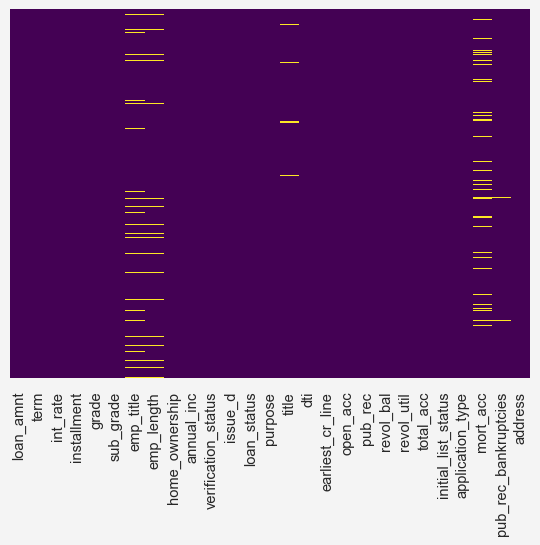

In [4]:
sns.heatmap(loandata.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Seems like there are some missing data in the `emp_length`, `emp_title`,
and `mort_acc` columns. Around 4.62$\%$ missing data in `emp_length`
column, 5.79$\%$ missing data in `emp_title` column, and 9.54$\%$ in the
`mort_acc` coulumn. Also, there is very small proportion, 0.07$\%$ of
missing data in the `revol_util` column. <br> <br> We need to take care
of this missing observations. We may drop the missing values if it is
insignificantly missing or doesn’t seem to be very strongly related to
the predictive/dependent variable.

In [6]:
loandata.describe().T

### Data Visualization

#### Loan Status

First, let’s look at the class balance in the dependent variable

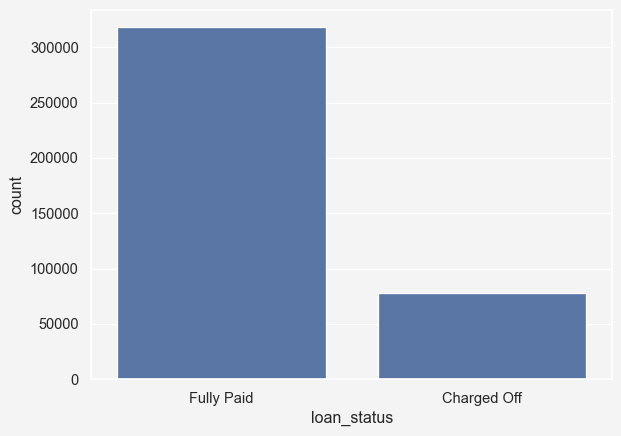

In [7]:
sns.countplot(x='loan_status', data=loandata)
fp = np.round(
    len(loandata[loandata['loan_status'] == 'Fully Paid'])/len(loandata)*100, 2
)

co = np.round(
    len(loandata[loandata['loan_status'] == 'Charged Off']) /
    len(loandata)*100, 2
)

So, 80.39$\%$ are `Fully Paid` category where as 19.61$\%$ is labeled as
`Charged Off` or defaulter.

**Insights: ** With 80.39 % labeled as “Fully Paid” and 19.61 % as
“Charged Off,” this dataset qualifies as moderately imbalanced. The
minority class (“Charged Off”) is well underrepresented, but not
severely so. This level of imbalance can still impact model performance,
especially if the model is biased towards predicting the majority class
. Techniques like resampling(oversampling the minority class or
undersampling the majority), using metrics like F1-score or AUC-ROC, or
even experimenting with algorithms specifically designed for imbalanced
datasets(such as XGBoost or balanced random forests) could be effective
ways to address this imbalance in the predictive modeling process.

#### Loan Amount and Installment Interaction With Loan Status

Next, let’s see how the features interacts with the dependent variable

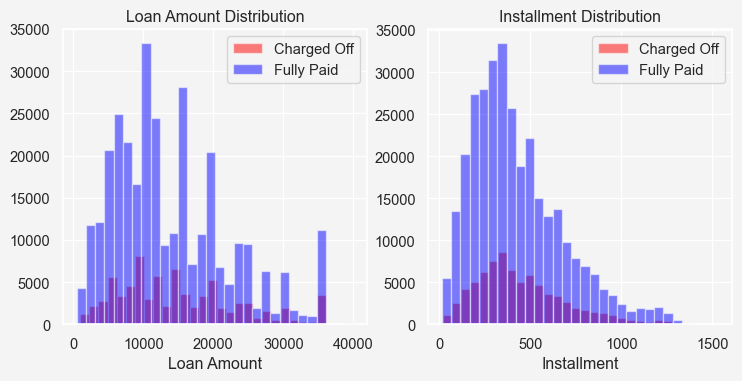

In [8]:
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(121)
loandata[loandata['loan_status'] == 'Charged Off']['loan_amnt'].hist(
    alpha=0.5, color='red', bins=30, ax=ax1,
    label='Charged Off'
)
loandata[loandata['loan_status'] == 'Fully Paid']['loan_amnt'].hist(
    alpha=0.5, color='blue', bins=30, ax=ax1,
    label='Fully Paid'
)
ax1.set_title('Loan Amount Distribution')
ax1.set_xlabel('Loan Amount')
ax1.legend()

ax2 = fig.add_subplot(122)
loandata[loandata['loan_status'] == 'Charged Off']['installment'].hist(
    alpha=0.5, color='red', bins=30, ax=ax2,
    label='Charged Off'
)
loandata[loandata['loan_status'] == 'Fully Paid']['installment'].hist(
    alpha=0.5, color='blue', bins=30, ax=ax2,
    label='Fully Paid'
)
ax2.set_title('Installment Distribution')
ax2.set_xlabel('Installment')
ax2.legend()

Both the `loan_amnt` and `installment` are slightly positively skewed.
How about their mean, upper quartile, lower quartile based on
`loan_status`?

Text(0.5, 1.0, 'Installment Boxplot')

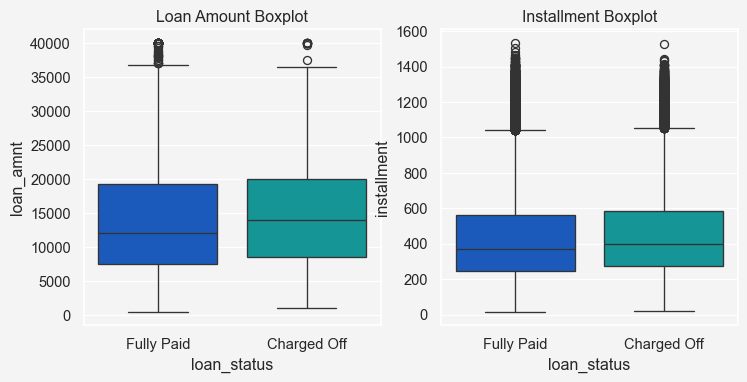

In [9]:
fig = plt.figure(figsize=(8.8, 4))
ax1 = fig.add_subplot(121)
sns.boxplot(
    x='loan_status', y='loan_amnt', hue='loan_status',
    data=loandata, ax=ax1, palette='winter'
)
ax1.set_title('Loan Amount Boxplot')

ax2 = fig.add_subplot(122)
sns.boxplot(
    x='loan_status', y='installment', hue='loan_status',
    data=loandata, ax=ax2, palette='winter'
)
ax2.set_title('Installment Boxplot')

**Insights: ** From the above plot we see that mean loan amount of the
fully paid and charged off categories are $\$12, 500$ and $\$14, 000$,
respectively.

#### Term, Grade, and Sub-grade Interaction With Loan Status

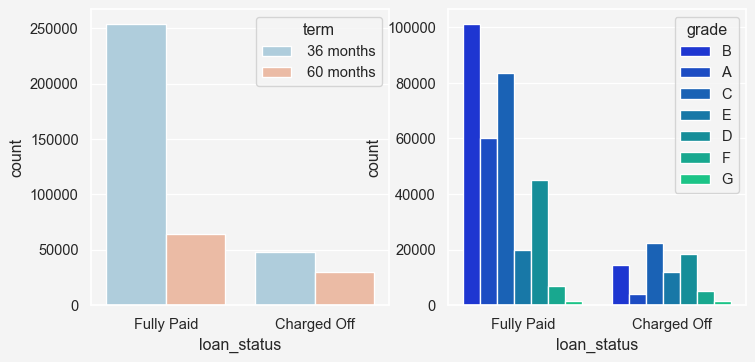

In [10]:
fig = plt.figure(figsize=(8.8, 4))
ax1 = fig.add_subplot(121)
sns.countplot(
    x='loan_status',
    hue='term', data=loandata,
    palette='RdBu_r', ax=ax1
)
ax2 = fig.add_subplot(122)
sns.countplot(
    x='loan_status',
    hue='grade', data=loandata,
    palette='winter', ax=ax2
)

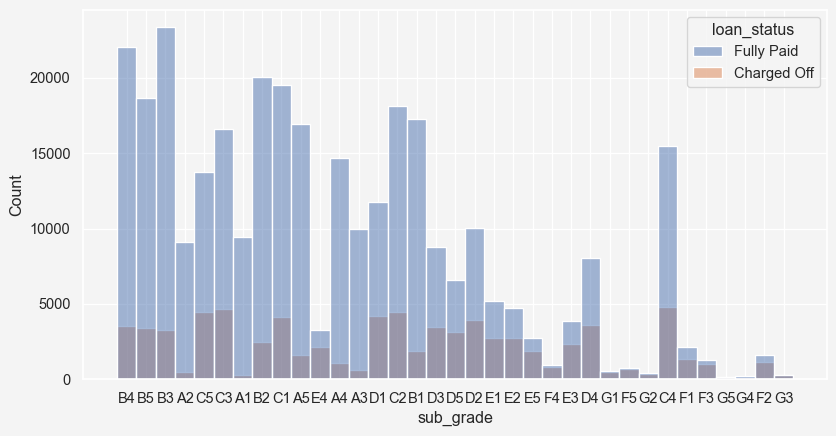

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(x='sub_grade', hue='loan_status', data=loandata, ax=ax)

#### Employment Title and Employment Length

In [12]:
loandata['emp_title'] = loandata['emp_title'].str.lower()
loandata.emp_title.value_counts()[:25]

emp_title
manager                     5635
teacher                     5426
registered nurse            2626
supervisor                  2589
sales                       2381
driver                      2306
owner                       2200
rn                          2072
project manager             1776
office manager              1638
general manager             1460
truck driver                1288
director                    1192
engineer                    1187
police officer              1041
vice president               961
sales manager                961
operations manager           960
store manager                941
president                    877
administrative assistant     865
accountant                   845
account manager              845
technician                   839
mechanic                     753
Name: count, dtype: int64

Let’s work with the employment length column

/var/folders/53/8y5n2fl55p3g3r5_pk9yfwk40000gn/T/ipykernel_91641/3832649202.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


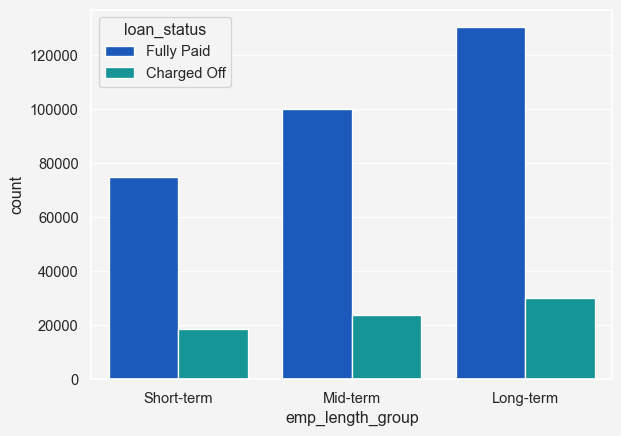

In [13]:
loandata['emp_length'] = loandata['emp_length'].replace({
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}
).infer_objects(copy=False)

loandata['emp_length_group'] = pd.cut(
    loandata['emp_length'],
    bins=[-1, 2, 7, 10],  # Bins: <3 years, 3-7 years, > 7 years
    labels=['Short-term', 'Mid-term', 'Long-term']
)

sns.countplot(
    x='emp_length_group',
    hue='loan_status',
    data=loandata,
    palette='winter',
    stat='count'
)

**Insights: ** So, from this plot we can see a trend. As employment
length goes up, the chances of fully paid gets higher, but the charged
of situation remains almost same, irrespective of the employment length.
Therefore, it may not be very useful when we may think of data
imputation for the missing values.

#### Home Ownership and Annual Income

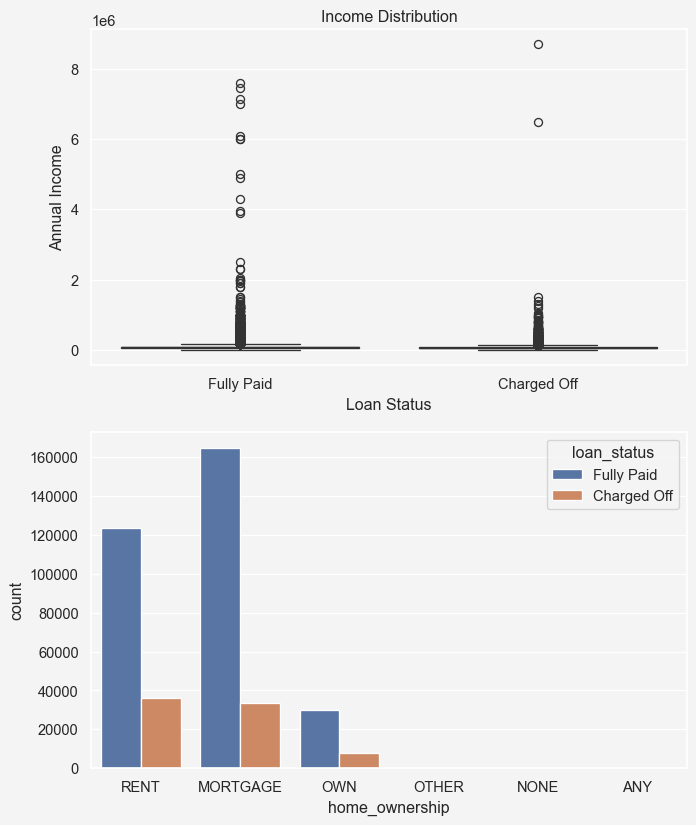

In [14]:
fig = plt.figure(figsize=(8, 10))
ax1 = fig.add_subplot(211)
sns.boxplot(
    x='loan_status', y='annual_inc',
    hue='loan_status', palette='winter',
    data=loandata, ax=ax1
)
ax1.set_title('Income Distribution')
ax1.set_xlabel('Loan Status')
ax1.set_ylabel('Annual Income')

ax2 = fig.add_subplot(212)
sns.countplot(
    x='home_ownership', hue='loan_status',
    data=loandata, ax=ax2
)

**Insights: ** From the Annual Income column, there is not enough
insights based on the plot. But for the Home Ownership plot shows that,
if the house is owned, it’s less likely to be charged off.

#### Issue Date and Verification Status

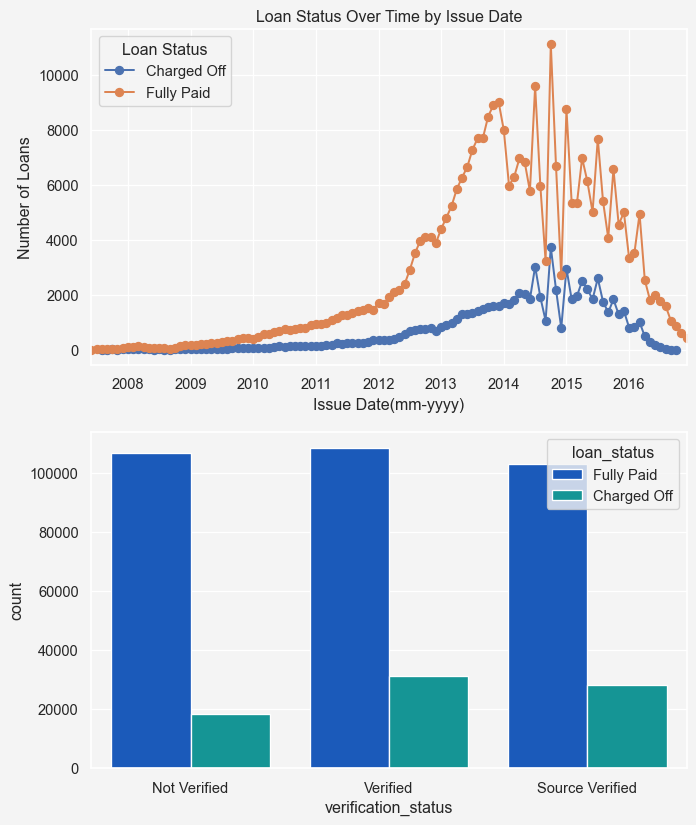

In [15]:
loandata['issue_d'] = pd.to_datetime(
    loandata['issue_d'], format='%b-%y'
)
loandata = loandata.sort_values('issue_d')
loan_status_trend = loandata.groupby(
    ['issue_d', 'loan_status']).size().unstack()

fig = plt.figure(figsize=(8, 10))
ax1 = fig.add_subplot(211)
loan_status_trend.plot(
    kind='line', marker='o', ax=ax1
)
ax1.set_title('Loan Status Over Time by Issue Date')
ax1.set_xlabel('Issue Date(mm-yyyy)')
ax1.set_ylabel('Number of Loans')
ax1.legend(title='Loan Status')

ax2 = fig.add_subplot(212)
sns.countplot(
    x='verification_status', hue='loan_status',
    data=loandata, palette='winter', ax=ax2
)

**Insights: ** From issue date plot we see that most of loans that were
marked as charged off happened during the year 2012 to 2016, with the
pick in in 2015. For the verification status, we can see the less
charged off incidents when the source was not varified.

#### Purpose and Debt-to-Income Ratio

Text(0.5, 1.0, 'Debt-to-Income Ratio on Loan Status')

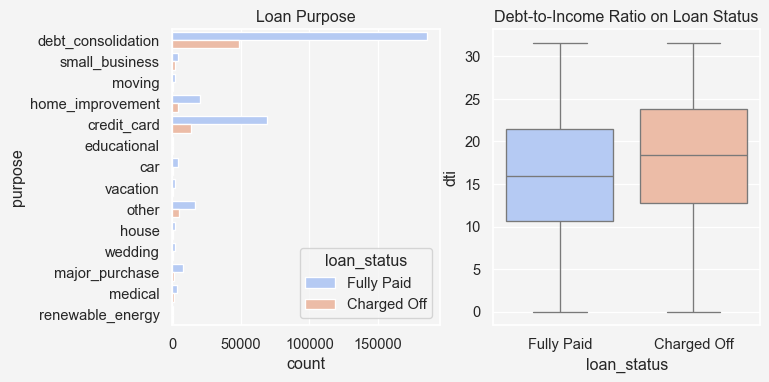

In [16]:
loandata['purpose'].value_counts()
fig = plt.figure(figsize=(7.9, 4))
ax1 = fig.add_subplot(121)
sns.countplot(
    y='purpose', hue='loan_status',
    data=loandata, palette='coolwarm'
)
ax1.set_title('Loan Purpose')

ax2 = fig.add_subplot(122)
dti_threshold = loandata['dti'].quantile(0.95)
filtereddata = loandata[loandata['dti'] <= dti_threshold]

sns.boxplot(
    x='loan_status', y='dti',
    hue='loan_status', data=filtereddata,
    palette='coolwarm', ax=ax2
)
ax2.set_title('Debt-to-Income Ratio on Loan Status')

**Insights:** From the purpose column, we see that most of the loans
that were charged off were used to make debt consolidation. Therefore,
debt consolidation may have been a significant factor when a loan is
charged off. Another insight we obtain from the debt-to-income ratio is
that the charged off loans have higher dti ratio

#### Number of Credit Accounts and Number of Public Records

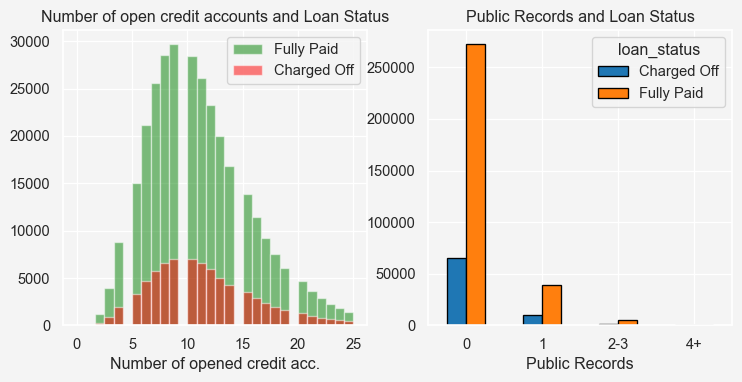

In [17]:
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(121)
filtered_open_account_threshold = loandata['open_acc'].quantile(0.98)
filtered_open_account = loandata[loandata['open_acc']
                                 <= filtered_open_account_threshold]
filtered_open_account[filtered_open_account['loan_status'] == 'Fully Paid']['open_acc'].hist(
    alpha=0.5, color='green', bins=30,label='Fully Paid' ,ax=ax1
)
filtered_open_account[filtered_open_account['loan_status'] == 'Charged Off']['open_acc'].hist(
    alpha=0.5, color='red', bins=30,label='Charged Off' ,ax=ax1
)
ax1.set_xlabel('Number of opened credit acc.')
ax1.legend()
ax1.set_title('Number of open credit accounts and Loan Status')

loandata['pub_rec_group'] = pd.cut(
    loandata['pub_rec'], bins=[-1, 0, 1, 3, loandata['pub_rec'].max()],
    labels=['0', '1', '2-3', '4+']
)
loan_status_by_pub_rec = loandata.groupby(
    ['pub_rec_group', 'loan_status'], observed=False
).size().unstack()

ax2 = fig.add_subplot(122)
loan_status_by_pub_rec.plot(
    kind='bar', stacked=False, edgecolor='black',
    color=['#1f77b4', '#ff7f0e'], ax=ax2
)
ax2.set_title('Public Records and Loan Status')
ax2.set_xlabel('Public Records')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

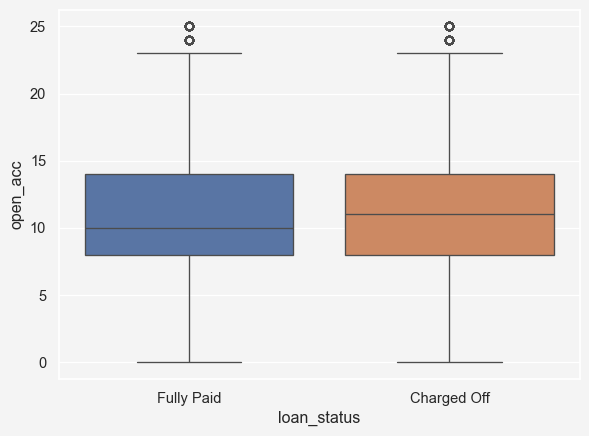

In [18]:
sns.boxplot(
    y='open_acc', x='loan_status',
    hue='loan_status',
    data=filtered_open_account
)

**Insights:** Number of credit account seems normally distributed among
both groups except for some outliers. However, the mean number of credit
accounts are slightly higher for the charged off category than the fully
paid category. So, higher credit account has some sort of relation with
loan being charged off. Also, people who doesn’t have any public record
seems to have higher chance of loan status being charged off

#### Revolving Balance and Utilization

Text(0.5, 1.0, 'Revolving Utilization vs Loan Status')

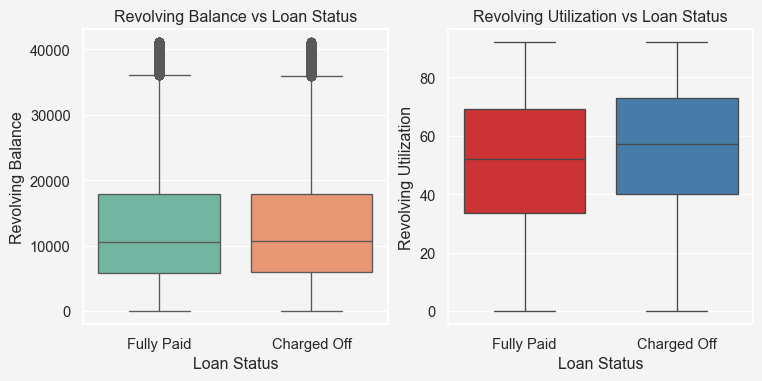

In [19]:
fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(121)
revol_bal_threshold = loandata['revol_bal'].quantile(0.95)
filtered_revol_bal = loandata[loandata['revol_bal']<=revol_bal_threshold]
sns.boxplot(
    x='loan_status', y='revol_bal',
    data=filtered_revol_bal, hue='loan_status',
    palette='Set2',ax=ax1
)
ax1.set_xlabel('Loan Status')
ax1.set_ylabel('Revolving Balance')
ax1.set_title('Revolving Balance vs Loan Status')

ax2 = fig.add_subplot(122)
revol_util_threshold = loandata['revol_util'].quantile(0.95)
filtered_revol_util = loandata[loandata['revol_util']<=revol_util_threshold]
sns.boxplot(
    x='loan_status', y='revol_util',
    hue='loan_status', data=filtered_revol_util,
    palette='Set1',ax=ax2
)
ax2.set_xlabel('Loan Status')
ax2.set_ylabel('Revolving Utilization')
ax2.set_title('Revolving Utilization vs Loan Status')

**Insights:** From the above plots, we don’t see much difference between
fully paid or charged off status regarding the revolving balance,
however, for revolving utilization, it’s higher for the charged off
category.

#### Total Account and Initial List Status

Text(0.5, 0, 'Initial Status (Funded or Withdrawn)')

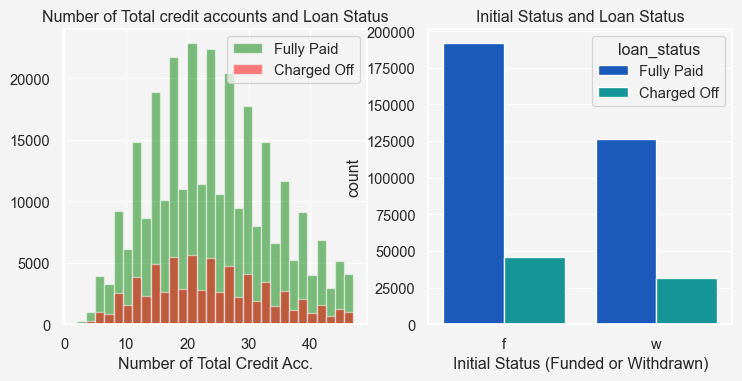

In [20]:
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(121)
filtered_total_account_threshold = loandata['total_acc'].quantile(0.95)
filtered_total_account = loandata[loandata['total_acc']
                                 <= filtered_total_account_threshold]
filtered_total_account[filtered_total_account['loan_status'] == 'Fully Paid']['total_acc'].hist(
    alpha=0.5, color='green', bins=30,label='Fully Paid' ,ax=ax1
)
filtered_total_account[filtered_total_account['loan_status'] == 'Charged Off']['total_acc'].hist(
    alpha=0.5, color='red', bins=30,label='Charged Off' ,ax=ax1
)
ax1.set_xlabel('Number of Total Credit Acc.')
ax1.legend()
ax1.set_title('Number of Total credit accounts and Loan Status')


ax2 = fig.add_subplot(122)
sns.countplot(
    x='initial_list_status',hue='loan_status',
    data=loandata, palette='winter'
)
ax2.set_title('Initial Status and Loan Status')
ax2.set_xlabel('Initial Status (Funded or Withdrawn)')

next,

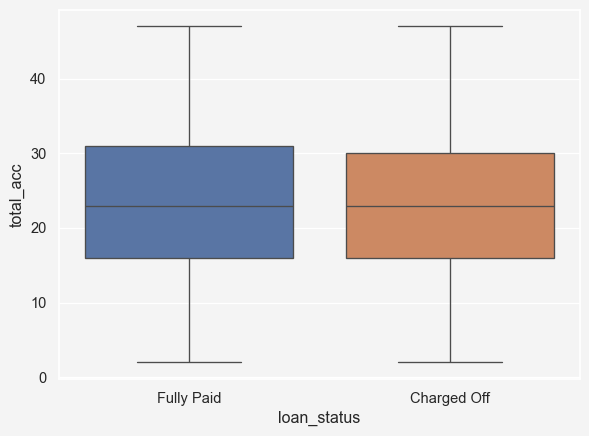

In [21]:
sns.boxplot(
    y='total_acc', x='loan_status',
    hue='loan_status',
    data=filtered_total_account
)

**Insights:** The number of total credit account seems to have no impact
on loan status based on the plottings above. Similarly, Initial Loan
Status also doesn’t give much information.

#### Number of Mortgage Account and Number of Public Record of Bankruptcies

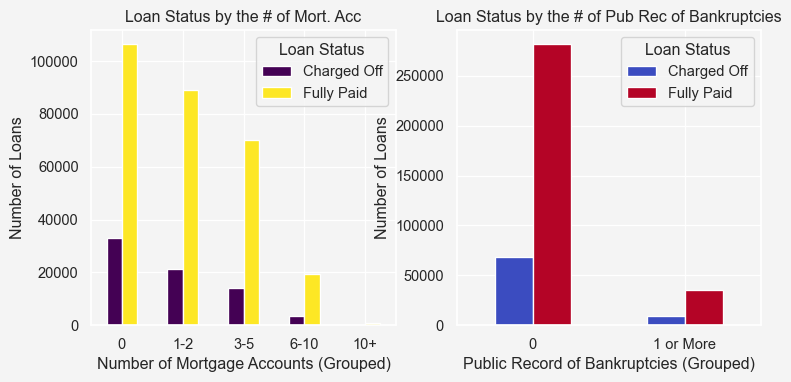

In [22]:
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(121)

loandata['mort_acc_group'] = pd.cut(
    loandata['mort_acc'], bins=[-1, 0, 2, 5, 10, loandata['mort_acc'].max()],
    labels=['0', '1-2', '3-5', '6-10', '10+']
)

mort_acc_counts = loandata.groupby(
    ['mort_acc_group', 'loan_status'],observed=False
).size().unstack()

mort_acc_counts.plot(
    kind='bar', stacked=False, 
    colormap='viridis', ax=ax1
)
ax1.set_title('Loan Status by the # of Mort. Acc')
ax1.set_xlabel('Number of Mortgage Accounts (Grouped)')
ax1.set_ylabel('Number of Loans')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.legend(title='Loan Status')

ax2 = fig.add_subplot(122)

loandata['pub_rec_bankruptcies_group'] = pd.cut(
    loandata['pub_rec_bankruptcies'], bins=[-1, 0, loandata['pub_rec_bankruptcies'].max()],
    labels=['0', '1 or More']
)

# Plot the grouped bar chart
pub_rec_bankruptcies_counts = loandata.groupby(
    ['pub_rec_bankruptcies_group', 'loan_status'],observed=False
).size().unstack()

pub_rec_bankruptcies_counts.plot(
    kind='bar', stacked=False,
    colormap='coolwarm', ax=ax2
)
ax2.set_title('Loan Status by the # of Pub Rec of Bankruptcies')
ax2.set_xlabel('Public Record of Bankruptcies (Grouped)')
ax2.set_ylabel('Number of Loans')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.legend(title='Loan Status')
plt.show()

**Insigths:** Again, loans where the applicants has less number of
mortgage acc or public record of bankruptcies are more likely to be
tagged as charged off.

#### Application Type

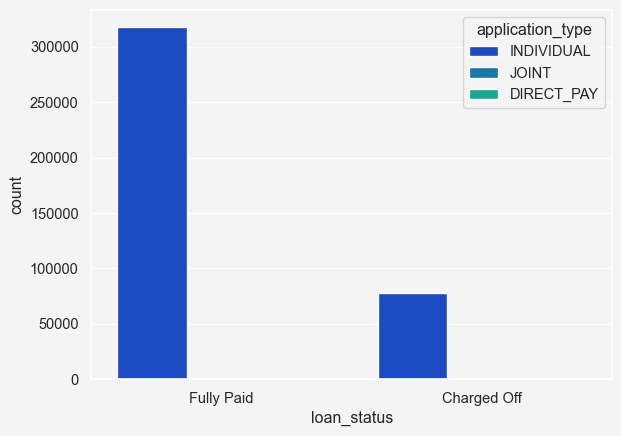

In [23]:
sns.countplot(
    x='loan_status', hue= 'application_type', 
    data=loandata, palette='winter'
)

We see only the individual type applications have impact on loans being
charged off.

Now that we have analyzed all the features, how about the correlations
among the features?

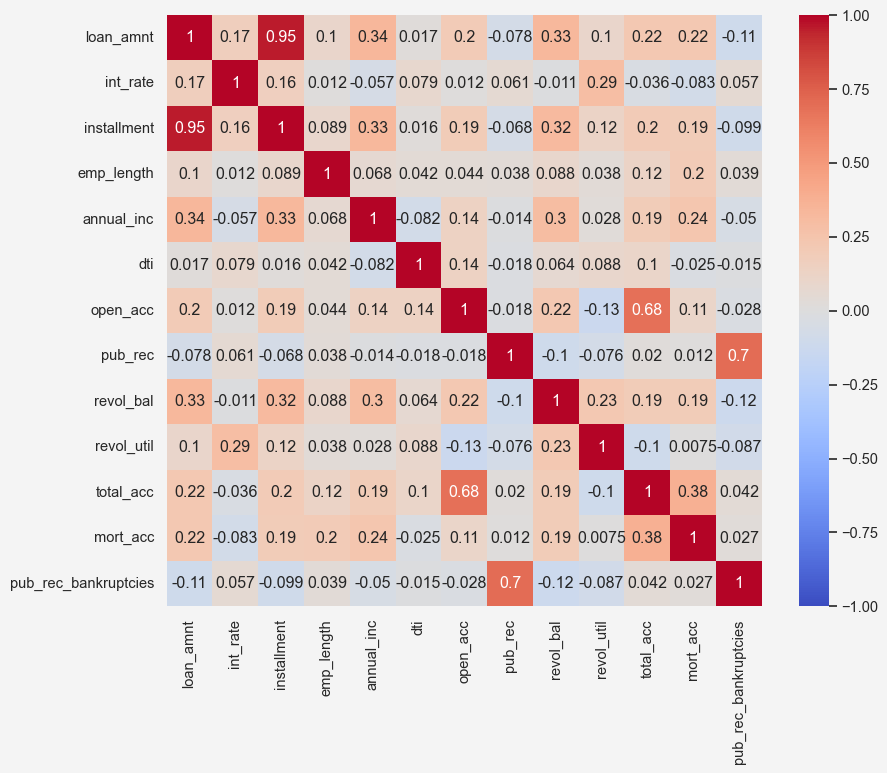

In [24]:
numeric_loandata = loandata.select_dtypes(include=['float64','int64'])
plt.figure(figsize=(10,8))
sns.heatmap(numeric_loandata.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

### Conclusion